In [1]:
from src.consts import IN_COLAB, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE
from src.dataset.split_dataset import split_dataset, copy_split_dataset

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import matplotlib.pyplot as plt
import torch

import src.dataset.oars_labels_consts as OARS_LABELS
from src.helpers.threshold_calc_helpers import get_threshold_info_df
from src.helpers.show_model_dataset_pred_preview import show_model_dataset_pred_preview
from src.dataset.dataset_cut_helpers import get_full_res_cut, get_cut_lists
from src.dataset.get_dataset import get_dataset
from src.dataset.get_dataset_info import get_dataset_info
from src.dataset.preview_dataset import preview_dataset
from src.model_and_training.prepare_model import prepare_model
from src.model_and_training.train_loop import train_loop
from src.model_and_training.training_helpers import show_model_info

from operator import itemgetter
from IPython.display import display, Markdown

torch.manual_seed(20)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Neural Network

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
print('low res dataset RAM sizes in GB', low_res_dataset.get_data_size() / 1024**3)

low_res_split_dataset_obj = split_dataset(low_res_dataset, train_size=40, valid_size=5, test_size=5)
get_dataset_info(low_res_dataset, low_res_split_dataset_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(low_res_split_dataset_obj)

CUDA using 16x dataset
normalizing dataset
filtering labels
dilatating 1x dataset
parsing dataset to numpy
data type: float64 int8
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 12.505709639268096, min -0.40698009878688973
label max 1, min 0


Output()

## training low res model

In [4]:
# preparing model loop params
low_res_model_info = prepare_model(epochs=30, in_channels=8, train_dataset=train_low_res_dataset, valid_dataset=valid_low_res_dataset, test_dataset=test_low_res_dataset)
show_model_info(low_res_model_info)

# getting everything necessary for model training
low_res_train_loop_params = {k:v for k,v in low_res_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
# running training loop
train_loop(**low_res_train_loop_params)

low_res_model = itemgetter('model')(low_res_model_info)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.97630, dsc 0.02370
Batch train [2] loss 0.97167, dsc 0.02833
Batch train [3] loss 0.97257, dsc 0.02743
Batch train [4] loss 0.96968, dsc 0.03032
Batch train [5] loss 0.97364, dsc 0.02636
Batch train [6] loss 0.96659, dsc 0.03341
Batch train [7] loss 0.95242, dsc 0.04758
Batch train [8] loss 0.96548, dsc 0.03452
Batch train [9] loss 0.96903, dsc 0.03097
Batch train [10] loss 0.96693, dsc 0.03307
Batch train [11] loss 0.96507, dsc 0.03493
Batch train [12] loss 0.97499, dsc 0.02501
Batch train [13] loss 0.95384, dsc 0.04616
Batch train [14] loss 0.95651, dsc 0.04349
Batch train [15] loss 0.95468, dsc 0.04532
Batch train [16] loss 0.96143, dsc 0.03857
Batch train [17] loss 0.96530, dsc 0.03470
Batch train [18] loss 0.96914, dsc 0.03086
Batch train [19] loss 0.96070, dsc 0.03930
Batch train [20] loss 0.96140, dsc 0.03860
Batch train [21] loss 0.95840,

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
normalizing dataset
filtering labels
parsing dataset to numpy
data type: float64 int8
full dataset RAM sizes in GB 18874368000
data max 12.81577046544424, min -0.40489707167932215
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## testing precoarse network


In [6]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model.to('cpu')
low_res_model.eval()
print('moved model to cpu')

moved model to cpu


### getting bounding box cut in full res

In [8]:
full_res_split_dataset_obj = copy_split_dataset(full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(full_res_dataset, full_res_split_dataset_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [9]:
dataset_index = 40
get_full_res_cut(low_res_model, low_res_dataset.data_list[dataset_index],
                 full_res_dataset.data_list[dataset_index], full_res_dataset.label_list[dataset_index],
                 low_res_mask_threshold=0.5,
                 desire_bounding_box_size=DESIRE_BOUNDING_BOX_SIZE, 
                 show_debug=True)

debug box delta [28 32 24]
debug, does cut and original label contain the same amount of pixels? True 951804 951804
debug bounding box sizes (44, 160, 144) (72, 192, 168)
debug bounding boxes (65, 108, 160, 319, 176, 319) (51, 122, 144, 335, 164, 331)


Output()

Output()

### running cut algorithm, creating cut dataset

In [10]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

getting cut index 0
debug box delta [19 32 24]
debug, does cut and original label contain the same amount of pixels? True 1223526 1223526
getting cut index 1
debug box delta [22 16 -8]
debug, does cut and original label contain the same amount of pixels? True 1326052 1326052
getting cut index 2
debug box delta [ 18   0 -24]
debug, does cut and original label contain the same amount of pixels? True 1890464 1890464
getting cut index 3
debug box delta [16 16  8]
debug, does cut and original label contain the same amount of pixels? True 1560217 1560217
getting cut index 4
debug box delta [20 32 -8]
debug, does cut and original label contain the same amount of pixels? True 1451227 1451227
getting cut index 5
debug box delta [20 32  8]
debug, does cut and original label contain the same amount of pixels? True 1262651 1262651
getting cut index 6
debug box delta [19 32 -8]
debug, does cut and original label contain the same amount of pixels? True 1566938 1566938
getting cut index 7
debug box d

### reviewing full res and cut dataset

In [11]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset.data_list[0].shape, full_res_dataset.label_list[0].shape)
print('cut full res shape', cut_full_res_dataset.data_list[0].shape, cut_full_res_dataset.label_list[0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, max_slices=72)

data type: float64 int8

full res shape (1, 160, 512, 512) (160, 512, 512)
cut full res shape (1, 72, 192, 168) (72, 192, 168)

dataset RAM sizes in GB 17.578125 0.9733200073242188
single item RAM in GB 0.0390625 0.3125

data max 11.780218856954171, min -0.42423961281850314
label max 22, min 0


Output()

### preparing cut model

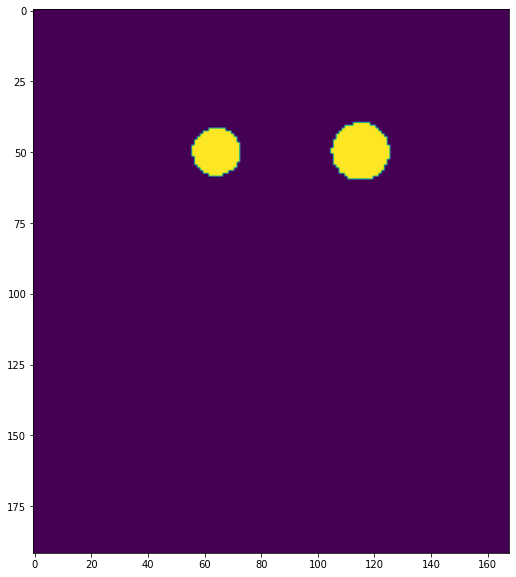

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [12]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_split_dataset_obj = copy_split_dataset(cut_full_res_dataset, low_res_split_dataset_obj)
get_dataset_info(cut_full_res_dataset, cut_split_dataset_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter(
    'train_dataset', 'valid_dataset', 'test_dataset')(cut_split_dataset_obj)

In [ ]:
cut_model_info = prepare_model(epochs=30,
                               learning_rate=5e-4,
                               in_channels=8,
                               train_dataset=cut_train_dataset, valid_dataset=cut_valid_dataset, test_dataset=cut_test_dataset)
show_model_info(cut_model_info)

cut_train_loop_params = {k:v for k,v in cut_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
train_loop(**cut_train_loop_params)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch train [1] loss 0.99714, dsc 0.00286
Batch train [2] loss 0.99630, dsc 0.00370
Batch train [3] loss 0.99535, dsc 0.00465
Batch train [4] loss 0.99437, dsc 0.00563
Batch train [5] loss 0.99417, dsc 0.00583
Batch train [6] loss 0.99108, dsc 0.00892
Batch train [7] loss 0.99189, dsc 0.00811
Batch train [8] loss 0.98928, dsc 0.01072
Batch train [9] loss 0.99562, dsc 0.00438
Batch train [10] loss 0.99328, dsc 0.00672
Batch train [11] loss 0.99015, dsc 0.00985
Batch train [12] loss 0.98953, dsc 0.01047
Batch train [13] loss 0.99409, dsc 0.00591
Batch train [14] loss 0.98942, dsc 0.01058
Batch train [15] loss 0.99220, dsc 0.00780
Batch train [16] loss 0.99086, dsc 0.00914
Batch train [17] loss 0.99014, dsc 0.00986
Batch train [18] loss 0.99226, dsc 0.00774
Batch train [19] loss 0.99313, dsc 0.00687
Batch train [20] loss 0.99175, dsc 0.00825
Batch train [21] loss 0.98877,

160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

### Cut Model evaluation

In [ ]:
max_slices = cut_train_dataset.__getitem__(0)[1].shape[0]

display((Markdown("#### Train Eval"),))
show_model_dataset_pred_preview(cut_model_info, cut_train_dataset, max_slices=max_slices, default_slice=49)

# display((Markdown("#### Valid Eval"),))
# show_model_dataset_pred_preview(cut_model_info, cut_valid_dataset, max_slices=max_slices, default_slice=53)

# display((Markdown("#### Test Eval"),))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

In [ ]:
### calculating best threshold

In [ ]:
dataset_index = 40
slice_index = 49

plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plt.imshow(preds[dataset_index][slice_index], cmap="gray", vmin=0, vmax=1)

plt.subplot(1, 3, 2)
plt.imshow(rescaled_preds[dataset_index][slice_index], cmap="gray", vmin=0, vmax=1)

plt.subplot(1, 3, 3)
plt.imshow(cut_full_res_dataset[dataset_index][1][slice_index], cmap="gray", vmin=0, vmax=1)
plt.show()